In [3]:
#挂载云盘 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#进入项目目录
print('original document')
!ls
import os
os.chdir('/content/drive/My Drive/colab/2020年C题')
print('current document')
!ls

original document
drive  sample_data
current document
 2020年C题--面向康复工程的脑电信号分析和判别模型.docx
'~$20年C题--面向康复工程的脑电信号分析和判别模型.docx'
 C-1-0.ipynb
 C-1-1.ipynb
 C-1-much-plot.ipynb
 C-2.1.ipynb
 C-2.2.ipynb
 c2_2.xlsx
 C-3.ipynb
 C-4-1.ipynb
 C-4-2.ipynb
 data.rar
 label-result.csv
 unrar.ipynb
 附件1-P300脑机接口数据
 附件2-睡眠脑电数据.xlsx


In [ ]:
#设置参数
import numpy as np
import pandas as pd

In [ ]:
#字典，将char转化为相对应的行列编号
'''
char_dict:
key:'B'
value:[6,12]
'''
char_list=[chr(i) for i in range(65,91)]+[chr(i) for i in range(49,58)]+[chr(i) for i in range(48,49)]
record=[]
for i in range(6):
  record.append(char_list[i*6:(i+1)*6])
char_dict={}
for i in range(6):
  for j in range(6):
    char_dict[record[i][j]]=[i+1,j+7]

#字典，将表头转化为相对应char
'''
event_dict:
key:102
value:'B'
'''
event_dict={}
record=[]
for i in range(len(char_list)):
  event_dict[i+101]=char_list[i]

In [ ]:
from scipy import stats #scipy中的stats可以做统计推断
#实现对原始数据对预处理 去均值等
def raw_data_preprocessing(data):
  #data=(data-data.min())/(data.max()-data.min())
  data=data-data.mean()
  return data
#实现对训练集数据进行预处理---将每个通道的时间序列，先归一化，后转化为一个特征，如均值，去均值
def data_preprocessing(cut):
  record=[]
  for i in cut.columns:
    temp_column=cut[i]
    temp_column=(temp_column-temp_column.min())/(temp_column.max()-temp_column.min())#预处理--归一化
    mu = np.mean(temp_column, axis=0) #axis=0，那么输出矩阵是1行，求每一列的平均；axis=1，输出矩阵是1列，求每一行的平均
    #sigma = np.std(temp_column, axis=0) #求标准差，这里除的是N
    #skew = stats.skew(temp_column) #求偏度
    #kurtosis = stats.kurtosis(temp_column) #求峰度 
    #median=temp_column.median()
    #quantile=temp_column.quantile(q=0.5)
    #skew=temp_column.skew()
    #mean_column=temp_column.mean()
    record.append(mu)
  return np.array(record)

In [ ]:
from sklearn.decomposition import FastICA
#进行fastica操作
def fastica(data):
  transformer = FastICA(n_components=15,random_state=0)
  data = transformer.fit_transform(data)
  data=pd.DataFrame(data)
  return data
#是否是当前的char
def is_current_char(action,char_dict,current_char):
  result=0
  if action in char_dict[current_char]:
    result=1
  return result
#根据当前char生成对应数据集
def data_generate(data,event,cut_begin,cut_end):
  '''
  input:
  current_char 当前字符
  data 数据集
  event 数据集
  cut_begin 截断区间
  cut_end 截断区间

  output:
  feature 特征
  label 标签
  '''
  record=[]
  record2=[]
  #data=fastica(data)
  current_char_code=event.columns[0]
  current_char=event_dict[current_char_code]
  for i in event.index:
    if event.iloc[i,0]==100:
      continue
    action_time=event.iloc[i,1]
    action=event.iloc[i,0]
    cut=data.iloc[action_time+cut_begin//4:action_time+cut_end//4,:]
    cut_preprocessing=data_preprocessing(cut)
    label=is_current_char(action,char_dict,current_char)
    record.append(cut_preprocessing)
    record2.append(label)
  record=np.array(record)
  record2=np.array(record2)
  #print(event.shape,record.shape,record2.shape,'如果前三者行数相等，说明数据集构建没有问题')
  return record,record2
#获取一组可以画图的数据 原始数据
def get_plot_data(data,event,cut_begin,cut_end):
  '''
  input:
  current_char 当前字符
  data 数据集
  event 数据集
  cut_begin 截断区间
  cut_end 截断区间

  output:
  保存为excel
  '''
  record=[]
  record2=[]
  data=fastica(data)
  current_char_code=event.columns[0]
  current_char=event_dict[current_char_code]
  if current_char!='B':
    return
  writer=pd.ExcelWriter('get_plot_data_fastica.xlsx')
  for i in event.index:
    if event.iloc[i,0]==100:
      continue
    action_time=event.iloc[i,1]
    action=event.iloc[i,0]
    cut=data.iloc[action_time+cut_begin//4:action_time+cut_end//4,:]
    #cut_preprocessing=data_preprocessing(cut)
    label=is_current_char(action,char_dict,current_char)
    cut.to_excel(writer,sheet_name='id=%d,label=%d'%(i,label),index=0)
    writer.save() 
    writer.close()

In [ ]:
#对所有sheet都生成对应的训练测试集，并汇总
#代码结构还是有点差，比赛期间没时间改啦
def data_generate_sum(train_data_path,train_event_path,cut_begin,cut_end):
  df = pd.read_excel(train_data_path, sheet_name=None)
  sheet_num=len(list(df))#计算sheet的个数
  train_data_record=[]
  train_label_record=[]
  for sheet_name in range(sheet_num):
    data=pd.read_excel(train_data_path,sheet_name,header=None) 
    data=raw_data_preprocessing(data)
    #print(data.head())
    event=pd.read_excel(train_event_path,sheet_name) 
    #print(event.head())
    train_data,train_label=data_generate(data,event,cut_begin,cut_end)
    #get_plot_data(data,event,cut_begin,cut_end)#获取画图数据
    train_data_record.append(train_data)
    train_label_record.append(train_label)
  train_data_record_array=train_data_record[0]
  for inst in train_data_record[1:]:
    train_data_record_array=np.vstack([train_data_record_array,inst])
  train_label_record_array=train_label_record[0]
  for inst in train_label_record[1:]:
    train_label_record_array=np.hstack([train_label_record_array,inst])
  return train_data_record_array,train_label_record_array

In [ ]:
#第几个被试
def each_s_data_generate(s):
  train_data_path='附件1-P300脑机接口数据/S%d/S%d_train_data.xlsx'%(s,s)
  train_event_path='附件1-P300脑机接口数据/S%d/S%d_train_event.xlsx'%(s,s)
  cut_begin,cut_end=200,500#ms
  real_train_data,real_train_label=data_generate_sum(train_data_path,train_event_path,cut_begin,cut_end)
  return real_train_data,real_train_label

In [ ]:
train_data_record=[]
train_label_record=[]
for i in range(5):
  train_data,train_label=each_s_data_generate(i+1)
  train_data_record.append(train_data)
  train_label_record.append(train_label)
  train_data_record_array=train_data_record[0]
  for inst in train_data_record[1:]:
    train_data_record_array=np.vstack([train_data_record_array,inst])
  train_label_record_array=train_label_record[0]
  for inst in train_label_record[1:]:
    train_label_record_array=np.hstack([train_label_record_array,inst])

In [ ]:
print('通过shape看一下数据集的特征和标签有没有什么问题',train_data_record_array.shape,train_label_record_array.shape)

通过shape看一下数据集的特征和标签有没有什么问题 (3600, 20) (3600,)


In [ ]:
real_train_data,real_train_label=train_data_record_array,train_label_record_array
#归一化 
real_train_data_norm=(real_train_data-real_train_data.min())/(real_train_data.max()-real_train_data.min())
#不归一化 
#real_train_data_norm=real_train_data
real_train_data_norm[1:5]

array([[0.60232885, 0.40014108, 0.49608149, 0.55358471, 0.55501171,
        0.48666486, 0.534594  , 0.2585227 , 0.4210663 , 0.30312884,
        0.43642656, 0.2946958 , 0.53214398, 0.57660441, 0.53315365,
        0.33826482, 0.50146512, 0.50412873, 0.43897899, 0.59040824],
       [0.47391683, 0.61860248, 0.47786833, 0.58195413, 0.57025037,
        0.56329425, 0.64235367, 0.43982816, 0.38432994, 0.43825774,
        0.55968908, 0.41897568, 0.38016946, 0.42422488, 0.41998785,
        0.36220921, 0.42688991, 0.36326365, 0.35406655, 0.49348404],
       [0.38098066, 0.64976812, 0.39518102, 0.34273359, 0.53286674,
        0.40355316, 0.50628202, 0.46970461, 0.33190553, 0.26430227,
        0.4496686 , 0.33166289, 0.31719927, 0.37084436, 0.27060768,
        0.34501381, 0.38567208, 0.29288089, 0.2816629 , 0.53004031],
       [0.42815657, 0.47477555, 0.4202301 , 0.29027167, 0.29021225,
        0.30733608, 0.43411256, 0.47464537, 0.22725044, 0.3482814 ,
        0.27664613, 0.44786559, 0.45359587, 0

In [ ]:
## 下采样
train_y=np.array(real_train_label)
train=pd.concat([pd.DataFrame(real_train_data_norm),pd.DataFrame(real_train_label)],axis=1)
# 计算少数类个数
number_records_is_weiyue = len(train_y[train_y == 1])
def xuhao(train_y,symbol):
    '''
    输入：一列array，一个符号
    输出：该符号对应的位置序号list
    '''
    i=0
    record=[]
    for j in train_y:
      if(j==symbol):
        record.append(i)
      i=i+1
    return record
# 取得少数类样本的索引
is_weiyue_indices = np.array(xuhao(train_y,1))
# 取得多数类样本的索引
normal_indices = np.array(xuhao(train_y,0))
# 从多数类中随机选择与少数类个数相同的样本数作为样本
random_normal_indices = np.random.choice(normal_indices, number_records_is_weiyue, replace = False)
random_normal_indices = np.array(random_normal_indices)
# 合并随机取得的0类和全部的1类的索引
under_sample_indices = np.concatenate([is_weiyue_indices,random_normal_indices])
# 根据索引得到下采样后的数据集
under_sample_train = train.iloc[under_sample_indices,:]
#打乱
from sklearn.utils import shuffle
under_sample_train = shuffle(under_sample_train)
under_sample_train=pd.DataFrame(under_sample_train.values)
under_sample_train#最终的数据集

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.469921,0.655707,0.278569,0.450511,0.380631,0.312375,0.417067,0.410150,0.332901,0.503669,0.212581,0.378160,0.470918,0.418745,0.374654,0.311576,0.421286,0.477426,0.410872,0.391381,0.0
1,0.537653,0.577786,0.592174,0.622985,0.465554,0.592228,0.420667,0.351942,0.444717,0.348231,0.418813,0.329383,0.229333,0.376491,0.348557,0.406581,0.322542,0.321823,0.386266,0.323532,0.0
2,0.668066,0.580377,0.641198,0.505630,0.390627,0.565093,0.516134,0.488987,0.390510,0.471832,0.436523,0.451112,0.362060,0.386816,0.499429,0.378932,0.456343,0.490938,0.455519,0.459089,0.0
3,0.656492,0.641395,0.580224,0.485815,0.648582,0.471278,0.568343,0.531412,0.758457,0.405107,0.575587,0.412711,0.514832,0.550855,0.399057,0.558739,0.407015,0.408015,0.455561,0.407489,1.0
4,0.663905,0.604727,0.305678,0.609774,0.500946,0.626366,0.600558,0.597403,0.497071,0.621157,0.502858,0.597653,0.602040,0.546348,0.610453,0.535105,0.613434,0.597913,0.556036,0.569927,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.503675,0.368648,0.576477,0.606845,0.291156,0.470000,0.846123,0.609033,0.187851,0.506807,0.225839,0.420596,0.399997,0.389925,0.516570,0.777389,0.584039,0.542965,0.663709,0.538484,0.0
1196,0.492991,0.562949,0.536366,0.567005,0.397501,0.419708,0.794809,0.474801,0.168466,0.291333,0.151185,0.466929,0.526536,0.591375,0.270404,0.599908,0.498626,0.368209,0.569590,0.293511,0.0
1197,0.560311,0.588993,0.486864,0.636049,0.674809,0.251589,0.509677,0.165436,0.669744,0.261706,0.394836,0.272498,0.299598,0.522964,0.262931,0.513059,0.269217,0.254712,0.222137,0.261375,1.0
1198,0.298694,0.299670,0.475303,0.405384,0.531361,0.487732,0.298335,0.585348,0.479864,0.403878,0.307603,0.376915,0.465345,0.359373,0.369603,0.349448,0.343218,0.416024,0.330384,0.344259,0.0


In [ ]:
from sklearn.model_selection import cross_val_score
X,Y=under_sample_train.iloc[:,:-1],under_sample_train.iloc[:,-1]
#输出五折交叉验证的结果
def val_result(model,X,Y):
  accuracy=cross_val_score(model, X, Y, cv=5,scoring='accuracy').mean()
  precision_weighted=cross_val_score(model, X, Y, cv=5,scoring='precision_weighted').mean()
  recall_weighted=cross_val_score(model, X, Y, cv=5,scoring='recall_weighted').mean()
  f1_weighted=cross_val_score(model, X, Y, cv=5,scoring='f1_weighted').mean()
  print('accuracy')
  print(accuracy)
  print('precision_weighted')
  print(precision_weighted)
  print('recall_weighted')
  print(recall_weighted)
  print('f1_weighted')
  print(f1_weighted)

In [ ]:
#逻辑回归
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
val_result(model,X,Y)

accuracy
0.4616666666666667
precision_weighted
0.46153034752014566
recall_weighted
0.4616666666666667
f1_weighted
0.4610515709928281


In [ ]:
#决策树方法
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
model=DecisionTreeClassifier()
val_result(model,X,Y)

accuracy
0.4875
precision_weighted
0.48333182298812216
recall_weighted
0.4999999999999999
f1_weighted
0.4786861510204835


In [ ]:
#随机森林方法
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=2, random_state=0)
val_result(model,X,Y)

accuracy
0.4708333333333333
precision_weighted
0.4704311971456424
recall_weighted
0.4708333333333333
f1_weighted
0.4678365645334474


In [ ]:
#使用adaboost分类算法
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=100, random_state=0)
val_result(model,X,Y)

accuracy
0.4925
precision_weighted
0.49236526528618574
recall_weighted
0.4925
f1_weighted
0.49181386944558636


In [ ]:
#knn k近邻分类算法
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=7)
val_result(model,X,Y)

accuracy
0.49416666666666664
precision_weighted
0.4941698600973751
recall_weighted
0.49416666666666664
f1_weighted
0.49394335314190085


In [ ]:
#神经网络分类方法
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(8, ),random_state=1, max_iter=300)
val_result(model,X,Y)

accuracy
0.495
precision_weighted
0.49452811311637523
recall_weighted
0.495
f1_weighted
0.4880880692391994


In [ ]:
# 支持向量机SVM
from sklearn.svm import SVC  
model = SVC(kernel='rbf') 
val_result(model,X,Y)

accuracy
0.4841666666666667
precision_weighted
0.4840365197978955
recall_weighted
0.4841666666666667
f1_weighted
0.48313910595796494


In [ ]:
#线性支持向量机SVM
from sklearn.svm import LinearSVC
model = LinearSVC() 
val_result(model,X,Y)

accuracy
0.45999999999999996
precision_weighted
0.4598516321107051
recall_weighted
0.45999999999999996
f1_weighted
0.45911966035561946


In [ ]:
#使用bagging的集成策略分类 元分类器是KNN
from sklearn.ensemble import BaggingClassifier
model = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=7),
                        n_estimators=10, random_state=0)
val_result(model,X,Y)

accuracy
0.5016666666666667
precision_weighted
0.5016938479723149
recall_weighted
0.5016666666666667
f1_weighted
0.5010088660483896


In [ ]:
#使用bagging的集成策略分类 元分类器是logistic
from sklearn.ensemble import BaggingClassifier
model = BaggingClassifier(base_estimator=LogisticRegression(),
                        n_estimators=10, random_state=0)
val_result(model,X,Y)


accuracy
0.4666666666666666
precision_weighted
0.4658484159507247
recall_weighted
0.4666666666666666
f1_weighted
0.4604191964236682


In [ ]:
#神经网络分类方法
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(8, ),random_state=1, max_iter=300)
val_result(model,X,Y)

accuracy
0.495
precision_weighted
0.49452811311637523
recall_weighted
0.495
f1_weighted
0.4880880692391994


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=2, random_state=0)
model.fit(X,Y)
feature_important=model.feature_importances_
print('特征重要程度',feature_important)

特征重要程度 [0.02440414 0.04042555 0.0468317  0.08373369 0.06645392 0.0879309
 0.02873013 0.05586543 0.06254737 0.01034426 0.06740945 0.08323009
 0.04459077 0.0733482  0.03906032 0.0460409  0.05166719 0.03137432
 0.0321219  0.02388977]


In [ ]:
###
pd.DataFrame([feature_important]).to_csv('S%d-feature-important.csv'%20)

In [ ]:
!ls

 2020年C题--面向康复工程的脑电信号分析和判别模型.docx
'~$20年C题--面向康复工程的脑电信号分析和判别模型.docx'
 C-1.ipynb
 data.rar
 get_plot_data_fastica.xlsx
 get_plot_data.xlsx
 S1-feature-important.csv
 S1-result.csv
 S1-result.gsheet
 S2-feature-important.csv
 S2-result.csv
 S2-result.gsheet
 S3-result.csv
 S3-result.gsheet
 S4-result.csv
 S4-result.gsheet
 S5-result.csv
 unrar.ipynb
 附件1-P300脑机接口数据
 附件2-睡眠脑电数据.xlsx


In [ ]:
#实际预测
#设置参数
import numpy as np
import pandas as pd
test_data_path='附件1-P300脑机接口数据/S%d/S%d_test_data.xlsx'%(s,s)
test_event_path='附件1-P300脑机接口数据/S%d/S%d_test_event.xlsx'%(s,s)
#最后采用的算法
model = AdaBoostClassifier(n_estimators=100, random_state=0)
model.fit(X,Y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [ ]:
#! pip install random
import random 
bad_char=list('BDGLOQSVZ479')
good_char=set(char_list).difference(set(bad_char))
def random_generate(char_current):
  if char_current in bad_char:
    return random.sample(good_char,1)[0]
  return char_current
#生成测试集数据
def data_generate_test(data,event,cut_begin,cut_end):
  '''
  input:
  current_char 当前字符
  data 数据集
  event 数据集
  cut_begin 截断区间
  cut_end 截断区间

  output:
  feature 特征
  label 标签
  '''
  record=[]
  record2=[]  
  data=fastica(data)
  for i in event.index:
    if event.iloc[i,0]==100:
      continue
    action_time=event.iloc[i,1]
    action=event.iloc[i,0]
    cut=data.iloc[action_time+cut_begin//4:action_time+cut_end//4,:]
    cut_preprocessing=data_preprocessing(cut)#预处理部分可以直接调用训练集的
    label=action
    record.append(cut_preprocessing)
    record2.append(label)
  record=np.array(record)
  record2=record2
  return record,record2
#从行列action组合映射到char
def action2char(col,row,char_dict):
  for char in char_dict.keys():
    if char_dict[char]==[col,row]:
      return char
#当前列表是否足够进行预测
def action_enough(record_list):
  col=[1,2,3,4,5,6]
  row=[7,8,9,10,11,12]
  for i in record_list:
    if i in col:
      for j in record_list:
        if j in row:
          return action2char(i,j,char_dict)
  return False
#预测时的预测逻辑，怎么从行列映射到字符
def calculate(real_test_label,predict):
  '''
  输入为 当下的action和对应的标签
  输出为 预测的轮数，预测的字符
  '''
  count=0
  record_list=[]
  for action in real_test_label:
    pred=predict[count]
    count+=1
    if pred==1:#预测到该action出现时，加入该action
      record_list.append(action)#当前预测到的action
      if action_enough(record_list)==False:
        continue
      if action_enough(record_list)!=False:
        return count,action_enough(record_list)
  return False,False
#测试集上的预测函数
def pred_test(real_test_data_norm,real_test_label,model):
  pred=model.predict(real_test_data_norm)
  epoch,determine=calculate(real_test_label,pred)
  determine=random_generate(determine)
  #print('the current epoch:',determine,int(epoch*6+4/0.9-5))
  epoch=int(epoch*3+4/0.9-5)
  print('the current epoch:',determine,epoch)
  #print('the current epoch:',determine,epoch)
  return determine,epoch
   
#对所有sheet都生成对应的训练测试集，并汇总 #代码结构还是有点差，比赛期间没时间改啦
def data_predict(train_data_path,train_event_path,cut_begin,cut_end):
  reocrd_epoch=[]
  df = pd.read_excel(train_event_path, sheet_name=None)
  sheet_num=len(list(df))#计算sheet的个数
  train_data_record=[]
  for sheet_name in range(sheet_num):
    data=pd.read_excel(train_data_path,sheet_name,header=None) 
    data=raw_data_preprocessing(data)
    event=pd.read_excel(train_event_path,sheet_name) 
    #print(data.head())
    real_test_data,real_test_label=data_generate_test(data,event,cut_begin,cut_end)
    #归一化 
    real_test_data_norm=(real_test_data-real_test_data.min())/(real_test_data.max()-real_test_data.min())#可能需要改动
    #不归一化 
    #real_train_data_norm=real_train_data
    current_char,epoch=pred_test(real_test_data_norm,real_test_label,model)
    train_data_record.append(current_char)
    reocrd_epoch.append(epoch)
  return train_data_record,reocrd_epoch
label,epoch=data_predict(test_data_path,test_event_path,cut_begin,cut_end)

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ValueError: ignored

In [ ]:
pd.DataFrame([label,epoch]).to_csv('S%d-result.csv'%s)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.read_excel('c2_2.xlsx',header=None)
dataset=pd.read_excel('c2_2.xlsx',header=None)
plt.figure(figsize=(3,2))
sns.heatmap(dataset.iloc[:,:],annot=False,cmap="YlGnBu")
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


FileNotFoundError: ignored

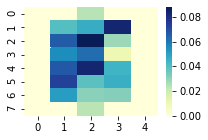

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.read_excel('c2_2.xlsx',header=None)
dataset=pd.read_excel('c2_2.xlsx',header=None)
plt.figure(figsize=(3,2))
sns.heatmap(dataset.iloc[:,:],annot=False,cmap="YlGnBu")
plt.show()